## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

def name_2_label_map(img_filename):
    '''Maps image names to labels names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    label_filename : string
        Filename of the corresponding label image
    '''  
    
    return img_filename.replace('.jpg', '.png').replace('.jpeg', '.png')

class SegLabelListCustom(SegmentationLabelList):
        def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [3]:
path = Path('river')
path_lbl = path/'train/labels/'
path_img = path/'train/images/'

## Subset classes

In [4]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('river/train/images/000000000036.jpg'),
 WindowsPath('river/train/images/000000000109.jpg'),
 WindowsPath('river/train/images/000000000540.jpg')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('river/train/labels/000000000036.png'),
 WindowsPath('river/train/labels/000000000109.png'),
 WindowsPath('river/train/labels/000000000540.png')]

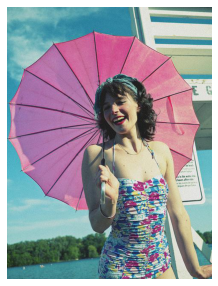

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

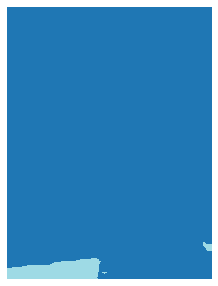

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([640, 481]), tensor([[[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Background', 'River'], dtype='<U10')

## Datasets

In [12]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 10546MB of GPU RAM free


In [13]:
src = (SegItemListCustom.from_folder(path_img)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

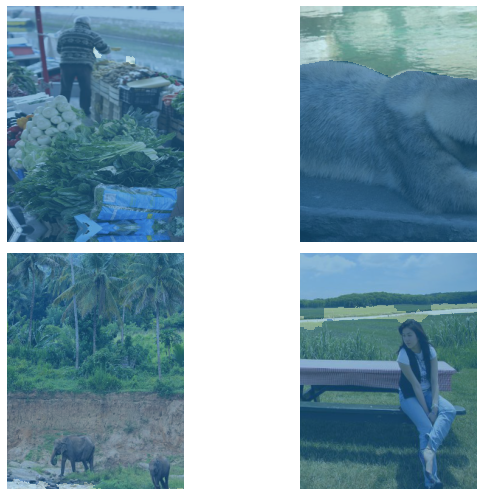

In [15]:
data.show_batch(2, figsize=(10,7))

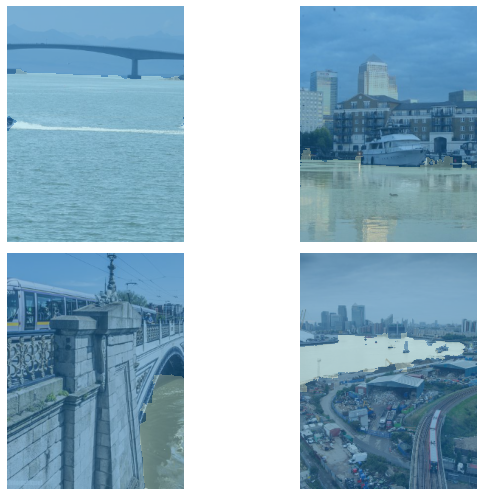

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    #mask = target != void_code
    return (input.argmax(dim=1)==target).float().mean()

In [18]:
metrics=acc_camvid
# metrics=accuracy

In [19]:
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch     train_loss  valid_loss  acc_camvid  time    
0         5.678151    #na#        00:39       
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


E:\Miniconda3\lib\site-packages\fastai\sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


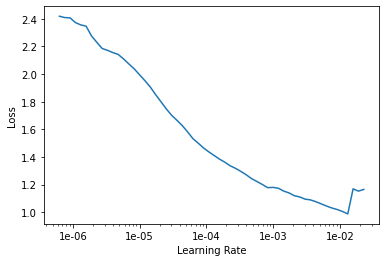

In [31]:
lr_find(learn)
learn.recorder.plot()

In [32]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch     train_loss  valid_loss  acc_camvid  time    
0         0.320174    0.257613    0.917415    03:33     
1         0.300640    0.272734    0.903171    02:48     
2         0.324536    0.455645    0.863096    02:44     
3         0.310104    0.297104    0.899912    02:41     


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

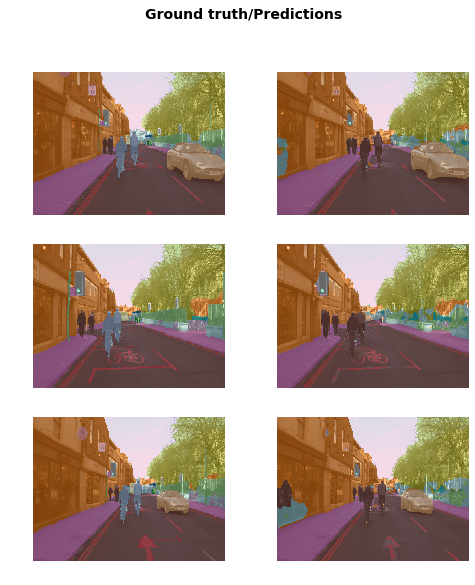

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.389135,0.334715,0.896700
2,0.377873,0.324080,0.900284
3,0.369020,0.325073,0.904146
4,0.355022,0.308820,0.912556
5,0.351138,0.313001,0.909351
6,0.347777,0.285509,0.920183
7,0.338683,0.306076,0.909899
8,0.318913,0.303712,0.915792
9,0.312038,0.276126,0.920137
10,0.311217,0.276649,0.925244


In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


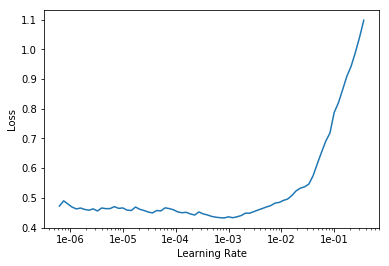

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

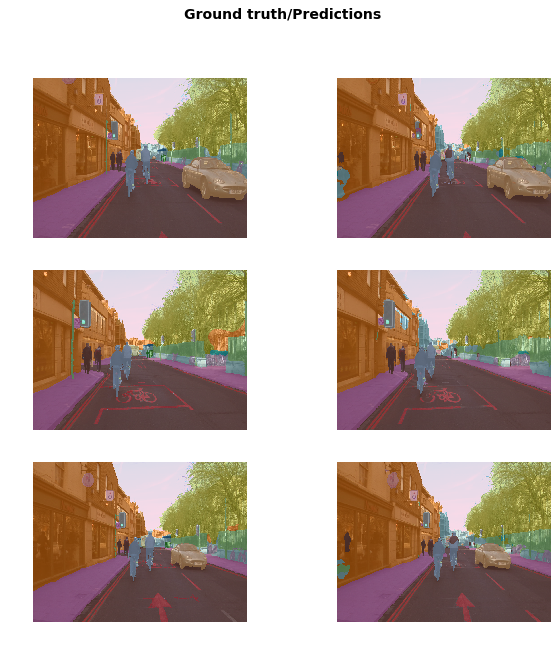

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin